# <font color='darkblue'> Topic Modeling and Entity Linking on Medium TDS Blogs</font>


In this notebook, we extract labels for the Towards Data Science blogposts, using topic modeling and key extraction. We also enhance these labels using Entity Linking.

##  <a class="anchor" id="Content-Recs">Workspace Setup</a>

In [1]:
# General libraries and packages

import pandas as pd
import numpy as np
import re
import pickle

# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Packages for dimensionality reduction
import umap.umap_ as umap

# Import clustering algorithms
import hdbscan

# Import key extraction algorithm
from keybert import KeyBERT

In [2]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

In [3]:
# Use 2 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 160)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", None)

##  <a class="anchor" id="Content-Recs">Upload Data</a>

In [4]:
# The preprocesed dataset of about 50K blogpost titles from TDS
df = pd.read_csv('data/data_interim/preprocessed_data.csv')
df.head(2)

,user_id,date,reading_time,title,subtitle,claps,responses,story_url,year,month,day,story_id,corpus
0,e9ee1187182a,2021-03-01,4,Stop using numpy.random.seed(),How to set random seeds for individual classes in Python,150,1,https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f?source=collection_archive---------0-----------------------,2021,3,1,581a9972805f,Stop using numpy.random.seed() How to set random seeds for individual classes in Python
1,fa1913854e95,2021-03-01,11,Semi-Automated Exploratory Data Analysis (EDA) in Python,Comprehensive Data Exploration Process with…,1000,8,https://towardsdatascience.com/semi-automated-exploratory-data-analysis-eda-in-python-7f96042c9809?source=collection_archive---------1-----------------------,2021,3,1,7f96042c9809,Semi-Automated Exploratory Data Analysis (EDA) in Python Comprehensive Data Exploration Process with…


## <a class="anchor" id="Content-Recs">Create BERT Embeddings for Corpus</a>

In [5]:
# Transform the documents in corpus column into 768-dim real vectors
model = SentenceTransformer('all-mpnet-base-v2')
df['corpus_embeddings'] = df['corpus'].apply(lambda x: model.encode(x))

# Save to a pickle file
df.to_pickle("data/data_interim/corpus_embeddings.pkl")  

## <a class="anchor" id="Content-Recs">Reduce 768-Vectors to 50-Vectors</a>

In [10]:
# Use UMAP algorithm
# Reduce the dimensionality of the vectors to 50 while keeping the size of the local neighborhood to 15
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=50,
                       metric='cosine').fit_transform(list(df.corpus_embeddings))

In [7]:
# Add the embeddings to the dataframe
df['corpus_umap'] = embeddings.tolist()

# Save the dataframe with embeddings and reduced embeddings to a file
df.to_pickle("data/data_interim/corpus_reduced_embeddings.pkl")  

# Check the output
df.head(2)

,user_id,date,reading_time,title,subtitle,claps,responses,story_url,year,month,day,story_id,corpus,corpus_embeddings,corpus_umap
0,e9ee1187182a,2021-03-01,4,Stop using numpy.random.seed(),How to set random seeds for individual classes in Python,150,1,https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f?source=collection_archive---------0-----------------------,2021,3,1,581a9972805f,Stop using numpy.random.seed() How to set random seeds for individual classes in Python,"[-0.015508673, 0.017387664, 0.011090896, 0.043596867, 0.019987836, -0.00983416, 0.023042997, -0.0062963786, -0.03516235, -0.044177756, 0.018397503, -0.02622...","[9.918017387390137, 9.971224784851074, 8.048364639282227, 8.984411239624023, 3.426600694656372, 4.089240550994873, 5.785865306854248, 6.489516258239746, 7.1..."
1,fa1913854e95,2021-03-01,11,Semi-Automated Exploratory Data Analysis (EDA) in Python,Comprehensive Data Exploration Process with…,1000,8,https://towardsdatascience.com/semi-automated-exploratory-data-analysis-eda-in-python-7f96042c9809?source=collection_archive---------1-----------------------,2021,3,1,7f96042c9809,Semi-Automated Exploratory Data Analysis (EDA) in Python Comprehensive Data Exploration Process with…,"[-0.017430862, 0.012263453, -0.026665978, -0.024180569, 0.06560987, 0.04191554, -0.003287101, -0.030808592, -0.030539894, 0.021245122, 0.02971904, 0.0636558...","[9.897627830505371, 9.937583923339844, 8.100211143493652, 9.799227714538574, 5.841444969177246, 3.137568473815918, 6.911947727203369, 5.738077640533447, 6.8..."


## <a class="anchor" id="Content-Recs">Cluster the 50-Vectors with HDBSCAN</a>

In [11]:
# Cluster the documents with HDBSCAN 

# Initialize the clustering model

clusterer = hdbscan.HDBSCAN(algorithm='best', prediction_data=True,
                            approx_min_span_tree=True, gen_min_span_tree=True, 
                            min_cluster_size=100,
                            cluster_selection_epsilon = .1,
                            min_samples=1, p=None,
                            metric='euclidean',
                            cluster_selection_method='leaf')

# Fit the data
clusterer.fit(embeddings)

# Add hard clusters to the data
df['hard_labels'] = clusterer.labels_.tolist()

# Create soft clusters
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

# Add the soft cluster information to the data
closest_clusters = [np.argmax(x) for x in soft_clusters]
df['soft_labels'] = closest_clusters

In [10]:
# Save to pickle file
df.to_pickle("data/data_interim/corpus_clusters_embeddings.pkl")  

In [15]:
# Save a reduced dataframe for building KG
df_reduced = df.drop(['corpus_embeddings', 'corpus_umap'], axis=1)
df_reduced.to_csv("data/data_processed/cluster_data.csv", index=False)

## <a class="anchor" id="Content-Recs">Cluster Visualizations</a>

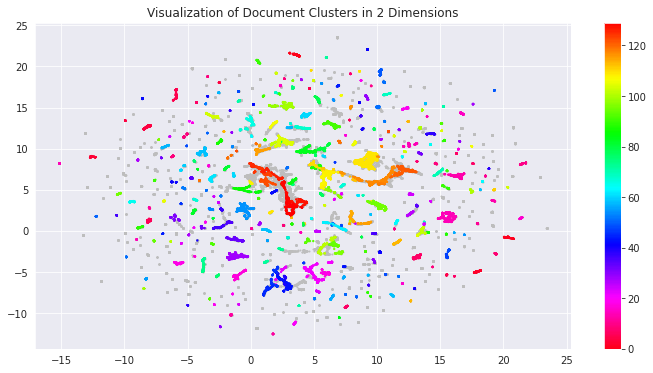

In [13]:
# Visualize the resulting hard clusters

# Prepare data by creating a 2-dim embedding for each 768-dim vector
umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, 
    min_dist=0.0, metric='cosine').fit_transform(embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize the clusters clusters
fig, ax = plt.subplots(figsize=(12, 6))
# Define the outliers and the clusters
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

#Create the plot
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1.0),
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1.8, cmap='hsv_r')
plt.colorbar();
plt.title('Visualization of Document Clusters in 2 Dimensions');

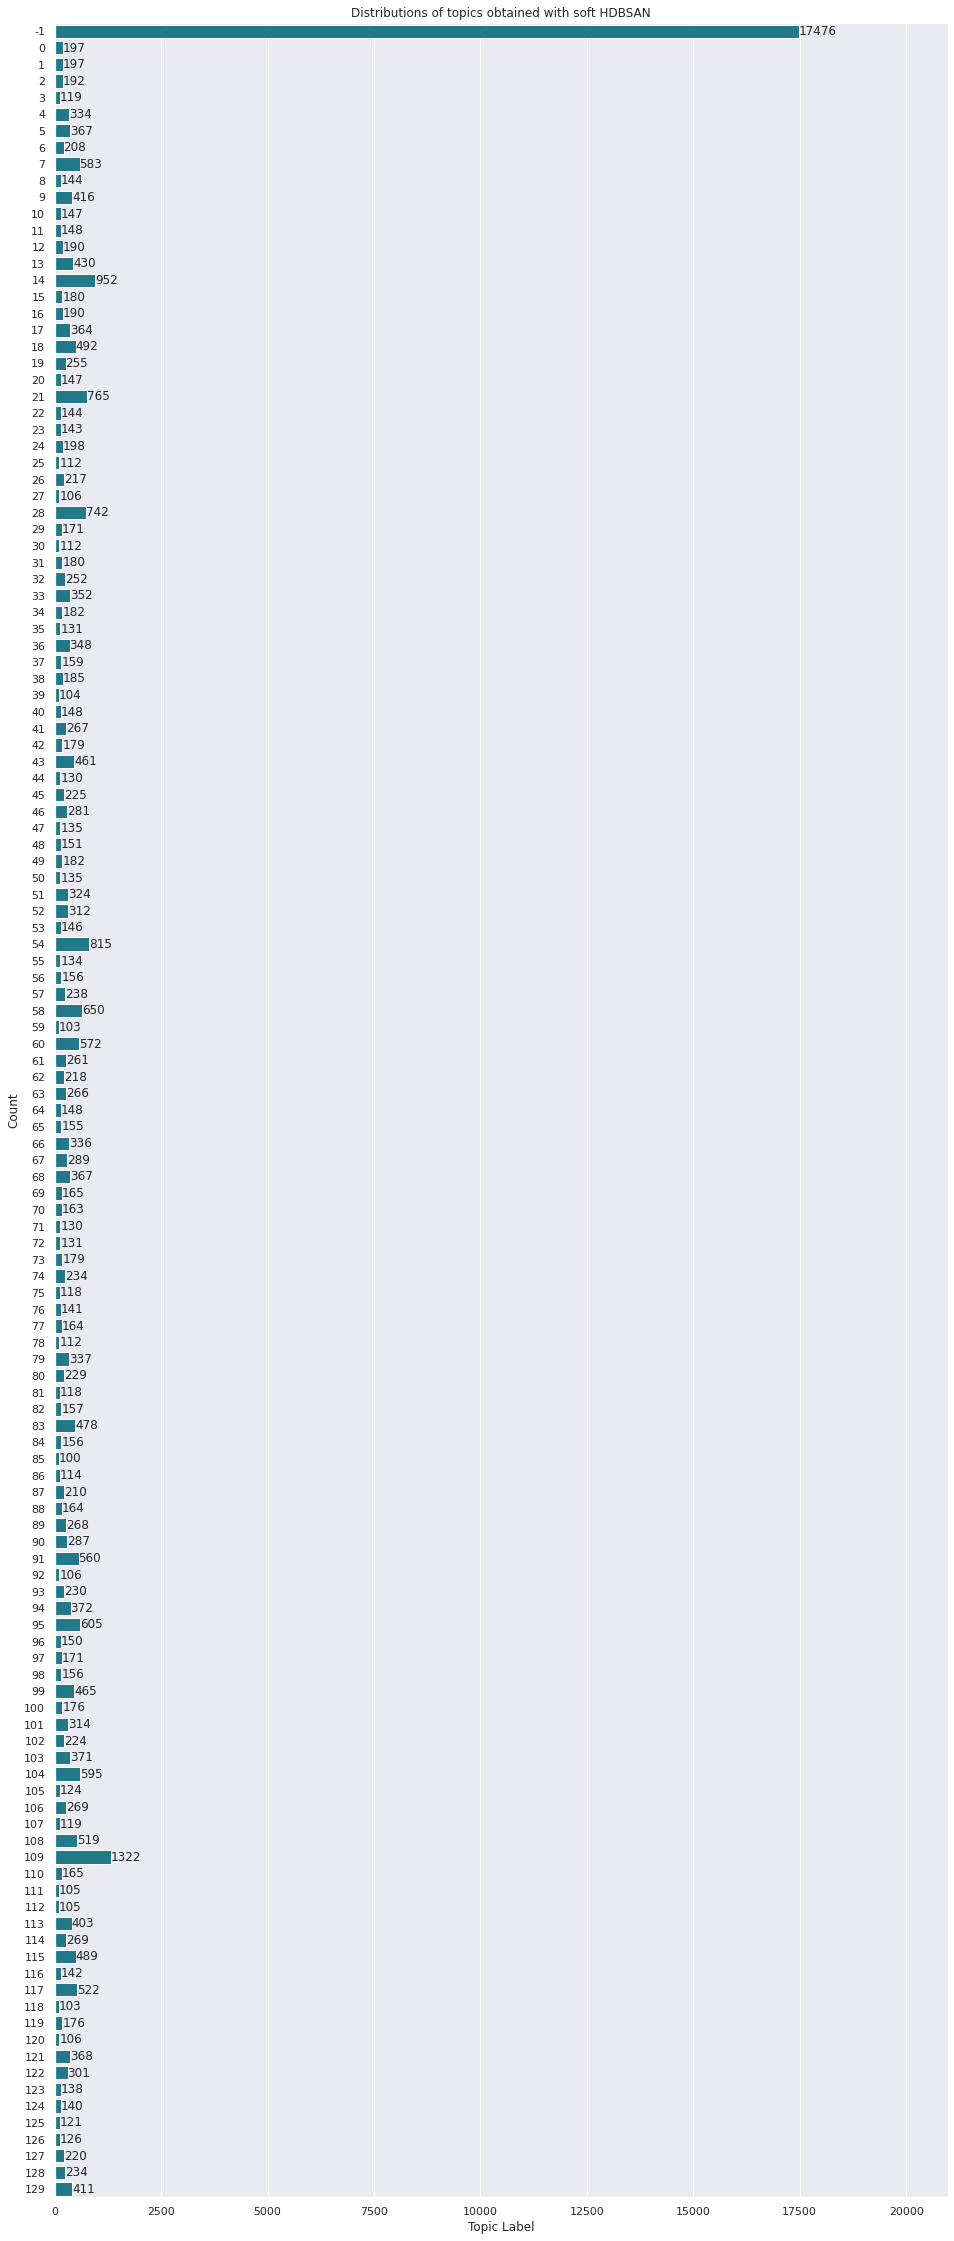

In [15]:
# Visualize the distribution articles by hard topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(16,40)})
sns.set(font_scale=1)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(y='hard_labels', data=df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with soft HDBSAN')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

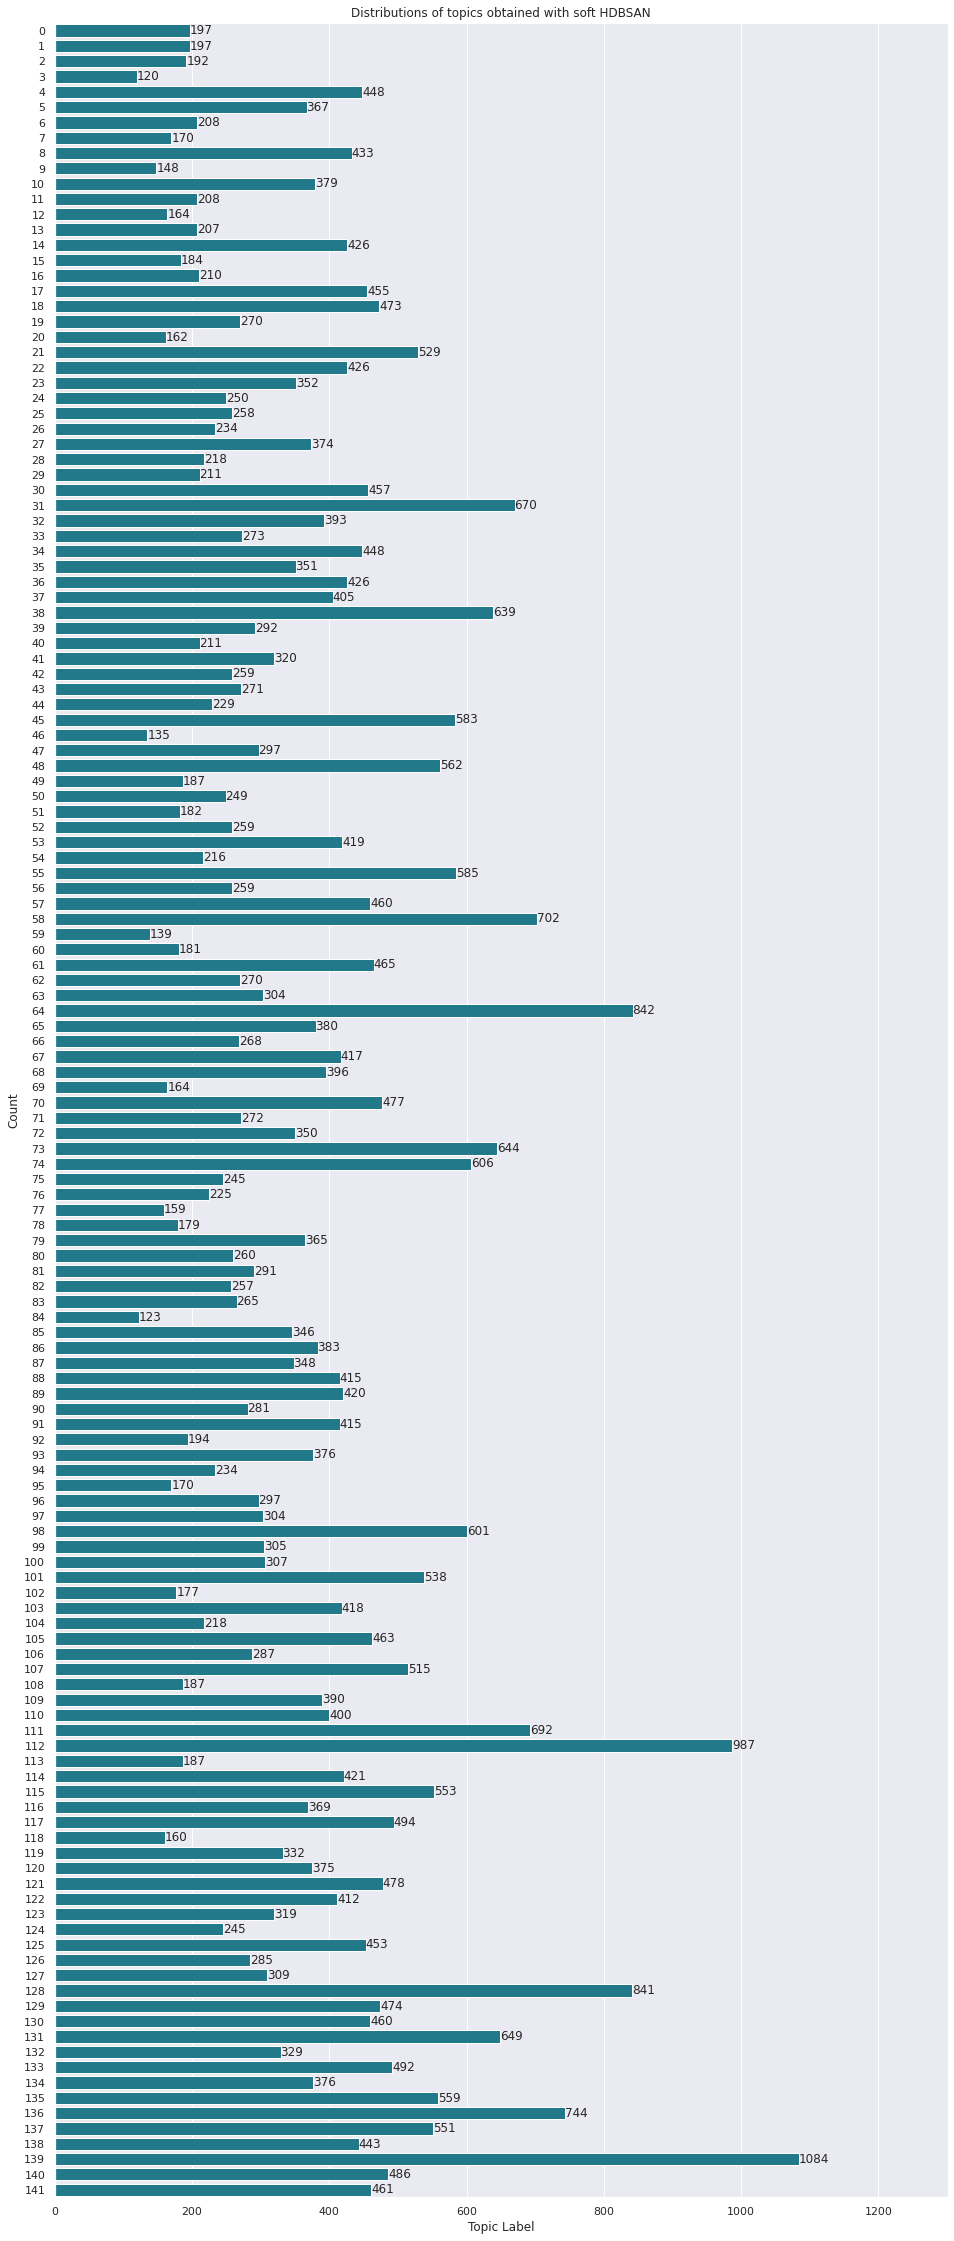

In [16]:
# Visualize the distribution articles by soft topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(16,40)})
sns.set(font_scale=1)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(y='soft_labels', data=df, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with soft HDBSAN')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul> - Noisy samples are given the label -1.</ul>
    <ul> - The labels for hard and soft clustering are usually different.</ul>
   <ul> - The hard clustering labels about a third of the data as noise, this number can be changed by adjusting the parameters min_cluster_size and min_samples, but without a significant reduction in the number of topics the size of the noise cluster will not considerably reduce. A smaller min_sample will reduce the noise cluster. Also increasing the min_cluster_size will help in eliminating noise. This is a known issue with HDBSCAN.</ul>
    <ul> - Since this is mostly experimental and investigative project, I chose to work with soft cluster instead. </ul>
</div>

In [17]:
# The number of hard clusters
len(df.hard_labels.unique())

131

In [18]:
# The number of soft clusters
len(df.soft_labels.unique())

142

## <a class="anchor" id="Content-Recs">Extract Phrases with keyBert</a>

In [5]:
# Upload the reduced data
df = pd.read_csv('data/data_processed/corpus_clusters.csv')

In [6]:
# Create a single combined document for each cluster of documents - use soft clustering
combined_df = df[['corpus', 'soft_labels']].copy()
combined_per_topic = combined_df.groupby(['soft_labels'], as_index=False).agg({'corpus': ' '.join})
combined_per_topic.head(2)

,soft_labels,corpus
0,0,How to make Sudo-Staccato Espresso with a Niche Grinder without a Sifter Coffee Data Science Improving Coffee Grind Distribution using Adaptive Thresholds C...
1,1,Visualize The Invisible Qubit Phase And learn how to tell the difference between the relative and the… Solving Sudoku with a Quantum Power-Up Being faster t...


<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul> - Use Maximal Marginal Relevance (MMR) to add diversity to the extracted chunks.</ul>
    <ul> - Choose a small values to avoid extraneous labels.</ul>
    
</div>

In [11]:
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer


# Instantiate the model
vectorizer = KeyphraseCountVectorizer()
#kw_model = KeyBERT('distilbert-base-nli-mean-tokens')
kw_model = KeyBERT()

def extract_keys(text):
    keywords = kw_model.extract_keywords(text, vectorizer=vectorizer,
                                         use_mmr=True)
    return keywords

In [12]:
# Evaluate the output on a sample text
text = combined_per_topic.corpus[3]
keywords = extract_keys(text)
print(keywords)

[('julia programming language', 0.7621), ('csv files', 0.4232), ('jupyter notebooks', 0.3031), ('plotting library', 0.2866), ('gentle introductory guide', 0.2664)]


In [13]:
# Extract keywords for each cluster
combined_per_topic['keywords'] = combined_per_topic['corpus'].apply(lambda x: extract_keys(x))
combined_per_topic.head()

,soft_labels,corpus,keywords
0,0,How to make Sudo-Staccato Espresso with a Niche Grinder without a Sifter Coffee Data Science Improving Coffee Grind Distribution using Adaptive Thresholds C...,"[(science improving coffee grind distribution, 0.6756), (espresso shot coffee particle distribution coffee data, 0.674), (small sample espresso filter compa..."
1,1,Visualize The Invisible Qubit Phase And learn how to tell the difference between the relative and the… Solving Sudoku with a Quantum Power-Up Being faster t...,"[(quantum computing learn, 0.7247), (understanding grover, 0.5423), (qubits means, 0.4893), (encrypted data, 0.1589), (mechanical properties, 0.0999)]"
2,2,How to balance a dataset in Python This tutorial belongs to the series How to improve the performance… 4 Ways to Improve Class Imbalance for Image Data Hand...,"[(imbalanced dataset techniques, 0.651), (borderline smote, 0.3763), (python handling class, 0.3032), (tensorflow, 0.2589), (practical tips, 0.2345)]"
3,3,Reading CSV files with Julia Learn how to use CSV.jl to read all kinds of comma-separated files Reading CSV files with Julia — Part 2 Custom formatting for ...,"[(julia programming language, 0.7621), (csv files, 0.4232), (jupyter notebooks, 0.3031), (plotting library, 0.2866), (gentle introductory guide, 0.2664)]"
4,4,"Introduction to Hierarchical clustering (part 1 — theory, linkage and affinity) What is hierarchical clustering, affinity measures and linkage measures How ...","[(tutorials clustering types, 0.6656), (python unsupervised learning hierarchical clustering, 0.6082), (tomato clustering, 0.5494), (k_nearest_neighbors, 0...."


In [14]:
# Function to extract keywords list for each topic
def extract_keywords(list_keys):
    all_keywords = []
    all_keys = map(lambda x: x[0], list_keys)
    for i in all_keys: 
        all_keywords.append(i)
    return all_keywords

In [15]:
# Extract lists of 5 keywords for each topic
combined_per_topic['keywords_list'] = combined_per_topic['keywords'].apply(lambda x: extract_keywords(x))

In [16]:
# Place each keyword in a column

explode_combined = pd.DataFrame(combined_per_topic['keywords_list'].to_list(), 
                                columns=['key1','key2', 'key3', 'key4', 'key5'])
df_all = pd.concat([combined_per_topic, explode_combined], axis=1)

In [17]:
# Save to a file
df_all.to_csv('data/data_processed/combined_corpus_topics.csv', index=False)

In [18]:
df = pd.read_csv('data/data_processed/combined_corpus_topics.csv')
df.head(2)

,soft_labels,corpus,keywords,keywords_list,key1,key2,key3,key4,key5
0,0,How to make Sudo-Staccato Espresso with a Niche Grinder without a Sifter Coffee Data Science Improving Coffee Grind Distribution using Adaptive Thresholds C...,"[('science improving coffee grind distribution', 0.6756), ('espresso shot coffee particle distribution coffee data', 0.674), ('small sample espresso filter ...","['science improving coffee grind distribution', 'espresso shot coffee particle distribution coffee data', 'small sample espresso filter comparison', 'tds co...",science improving coffee grind distribution,espresso shot coffee particle distribution coffee data,small sample espresso filter comparison,tds coffee data,staccato espresso
1,1,Visualize The Invisible Qubit Phase And learn how to tell the difference between the relative and the… Solving Sudoku with a Quantum Power-Up Being faster t...,"[('quantum computing learn', 0.7247), ('understanding grover', 0.5423), ('qubits means', 0.4893), ('encrypted data', 0.1589), ('mechanical properties', 0.09...","['quantum computing learn', 'understanding grover', 'qubits means', 'encrypted data', 'mechanical properties']",quantum computing learn,understanding grover,qubits means,encrypted data,mechanical properties


## <a class="anchor" id="Content-Recs">Entity Linking with spaCy</a>

In [19]:
# https://github.com/egerber/spaCy-entity-linker

import spacy  

# initialize language model##
nlp = spacy.load("en_core_web_md")

# add to pipeline 
nlp.add_pipe("entityLinker", last=True)

In [20]:
# Test the model
doc = nlp("machine learning")

# returns all entities in the whole document
ent = doc._.linkedEntities[0]
# iterates over sentences and prints linked entities
for sent in doc.sents:
    sent._.linkedEntities.pretty_print()

<EntityElement: https://www.wikidata.org/wiki/Q2539 machine learning          branch of statistics and computer science, which studies algorithms and architectures that learn fro>


In [21]:
ent.get_description() # returns description from Wikidata

'branch of statistics and computer science, which studies algorithms and architectures that learn from observed facts'

In [22]:
ent.get_id() # returns Wikidata ID

2539

In [23]:
ent.get_label() # returns Wikidata label

'machine learning'

In [24]:
ent.get_span() # returns the span from the spacy document that contains the linked entity

machine learning

In [25]:
ent.get_url() # returns the url to the corresponding Wikidata item

'https://www.wikidata.org/wiki/Q2539'

In [26]:
ent.pretty_print() # prints out information about the entity element

<EntityElement: https://www.wikidata.org/wiki/Q2539 machine learning          branch of statistics and computer science, which studies algorithms and architectures that learn fro>


In [27]:
ent.get_sub_entities(limit=2) # returns EntityCollection of all entities that derive from the current entityElement

<EntityCollection (2 entities):
-https://www.wikidata.org/wiki/Q133580 Explanation-based learning                                                   
-https://www.wikidata.org/wiki/Q172491 data mining               computational process of discovering patterns in large data sets involving methods at the intersecti>

In [28]:
ent.get_super_entities(limit=2) # returns EntityCollection of all entities that the current entityElement derives from

<EntityCollection (2 entities):
-https://www.wikidata.org/wiki/Q11660 artificial intelligence   branch of computer science that develops machines and software with human-like intelligence
-https://www.wikidata.org/wiki/Q21198 computer science          study of the theoretical foundations of information and computation>

In [29]:
# Extract linked information
def get_linked_info(keyphrase):
    '''
    Function to extract linked information from Wikidata.
    INPUT:
        keyphrase (str)
    OUTPUT:
        linked_info (list)
    '''
    doc = nlp(keyphrase)
    if len(doc._.linkedEntities)>0:
        ent = doc._.linkedEntities[0]
        descrip = ent.get_description() # returns description from Wikidata
        wid = ent.get_id() # returns Wikidata ID
        wikilabel = ent.get_label() # returns Wikidata label
        linked_info = [descrip, wid, wikilabel]
    else:
        linked_info = ['no description','000', 'no_label']
    return linked_info

In [30]:
# The function output contains the retained information
get_linked_info("machine learning")

['branch of statistics and computer science, which studies algorithms and architectures that learn from observed facts',
 2539,
 'machine learning']

In [31]:
# There is no linked information in this case
get_linked_info("science improving coffee grind distribution")

['study and knowledge of the natural world; the natural and social sciences',
 336,
 'science']

In [32]:
# Get the metadata for each of the key columns
key_columns = ['key1', 'key2', 'key3', 'key4', 'key5']
for col in key_columns:
    meta_col = f'meta_{col}'
    df[meta_col] = df[col].apply(lambda x: get_linked_info(x))

In [33]:
# Check the output
df.head(2)

,soft_labels,corpus,keywords,keywords_list,key1,key2,key3,key4,key5,meta_key1,meta_key2,meta_key3,meta_key4,meta_key5
0,0,How to make Sudo-Staccato Espresso with a Niche Grinder without a Sifter Coffee Data Science Improving Coffee Grind Distribution using Adaptive Thresholds C...,"[('science improving coffee grind distribution', 0.6756), ('espresso shot coffee particle distribution coffee data', 0.674), ('small sample espresso filter ...","['science improving coffee grind distribution', 'espresso shot coffee particle distribution coffee data', 'small sample espresso filter comparison', 'tds co...",science improving coffee grind distribution,espresso shot coffee particle distribution coffee data,small sample espresso filter comparison,tds coffee data,staccato espresso,"[study and knowledge of the natural world; the natural and social sciences, 336, science]","[brewed beverage prepared from roasted coffee seeds, 8486, coffee]","[A kind of coffee, 180289, espresso]","[brewed beverage prepared from roasted coffee seeds, 8486, coffee]","[form of musical articulation, 466944, staccato]"
1,1,Visualize The Invisible Qubit Phase And learn how to tell the difference between the relative and the… Solving Sudoku with a Quantum Power-Up Being faster t...,"[('quantum computing learn', 0.7247), ('understanding grover', 0.5423), ('qubits means', 0.4893), ('encrypted data', 0.1589), ('mechanical properties', 0.09...","['quantum computing learn', 'understanding grover', 'qubits means', 'encrypted data', 'mechanical properties']",quantum computing learn,understanding grover,qubits means,encrypted data,mechanical properties,"[theoretical computation device relying on quantum mechanics, 176555, quantum computer]","[American basketball player, 5256411, Tim Hardaway Jr.]","[unit of quantum information, analogous to the classical bit; the information carried by a 2-state quantum-mechanical system, e.g. polarization of a photon ...","[facts represented for handling, 42848, data]","[physical or intangible entity, owned by a person or a group of people, 6422240, property]"


In [34]:
# Extract each meta data keyword in a column 

for col in key_columns:
    meta_key = f'meta_{col}'
    meta_columns = [f'{meta_key}_description', f'{meta_key}_wid', f'{meta_key}_wikilabel']
    explode_df = pd.DataFrame(df[meta_key].to_list(), columns=meta_columns)
    df = pd.concat([df, explode_df], axis=1)

In [35]:
# Check the output
df.head(2)

,soft_labels,corpus,keywords,keywords_list,key1,key2,key3,key4,key5,meta_key1,...,meta_key2_wikilabel,meta_key3_description,meta_key3_wid,meta_key3_wikilabel,meta_key4_description,meta_key4_wid,meta_key4_wikilabel,meta_key5_description,meta_key5_wid,meta_key5_wikilabel
0,0,How to make Sudo-Staccato Espresso with a Niche Grinder without a Sifter Coffee Data Science Improving Coffee Grind Distribution using Adaptive Thresholds C...,"[('science improving coffee grind distribution', 0.6756), ('espresso shot coffee particle distribution coffee data', 0.674), ('small sample espresso filter ...","['science improving coffee grind distribution', 'espresso shot coffee particle distribution coffee data', 'small sample espresso filter comparison', 'tds co...",science improving coffee grind distribution,espresso shot coffee particle distribution coffee data,small sample espresso filter comparison,tds coffee data,staccato espresso,"[study and knowledge of the natural world; the natural and social sciences, 336, science]",...,coffee,A kind of coffee,180289,espresso,brewed beverage prepared from roasted coffee seeds,8486,coffee,form of musical articulation,466944,staccato
1,1,Visualize The Invisible Qubit Phase And learn how to tell the difference between the relative and the… Solving Sudoku with a Quantum Power-Up Being faster t...,"[('quantum computing learn', 0.7247), ('understanding grover', 0.5423), ('qubits means', 0.4893), ('encrypted data', 0.1589), ('mechanical properties', 0.09...","['quantum computing learn', 'understanding grover', 'qubits means', 'encrypted data', 'mechanical properties']",quantum computing learn,understanding grover,qubits means,encrypted data,mechanical properties,"[theoretical computation device relying on quantum mechanics, 176555, quantum computer]",...,Tim Hardaway Jr.,"unit of quantum information, analogous to the classical bit; the information carried by a 2-state quantum-mechanical system, e.g. polarization of a photon (...",378201,qubit,facts represented for handling,42848,data,"physical or intangible entity, owned by a person or a group of people",6422240,property


In [36]:
# Save the metadata to a file
df.to_csv('data/data_processed/linked_corpus_metadata.csv', index=False)

In [37]:
cols_to_keep = ['soft_labels', 'key1', 'key2', 'key3', 'key4', 'key5', 
                'meta_key1_description', 'meta_key1_wid', 'meta_key1_wikilabel', 
                'meta_key2_description', 'meta_key2_wid','meta_key2_wikilabel', 
                'meta_key3_description', 'meta_key3_wid', 'meta_key3_wikilabel', 
                'meta_key4_description', 'meta_key4_wid','meta_key4_wikilabel', 
                'meta_key5_description', 'meta_key5_wid', 'meta_key5_wikilabel']
dff = df[cols_to_keep]
dff.head(2)

,soft_labels,key1,key2,key3,key4,key5,meta_key1_description,meta_key1_wid,meta_key1_wikilabel,meta_key2_description,...,meta_key2_wikilabel,meta_key3_description,meta_key3_wid,meta_key3_wikilabel,meta_key4_description,meta_key4_wid,meta_key4_wikilabel,meta_key5_description,meta_key5_wid,meta_key5_wikilabel
0,0,science improving coffee grind distribution,espresso shot coffee particle distribution coffee data,small sample espresso filter comparison,tds coffee data,staccato espresso,study and knowledge of the natural world; the natural and social sciences,336,science,brewed beverage prepared from roasted coffee seeds,...,coffee,A kind of coffee,180289,espresso,brewed beverage prepared from roasted coffee seeds,8486,coffee,form of musical articulation,466944,staccato
1,1,quantum computing learn,understanding grover,qubits means,encrypted data,mechanical properties,theoretical computation device relying on quantum mechanics,176555,quantum computer,American basketball player,...,Tim Hardaway Jr.,"unit of quantum information, analogous to the classical bit; the information carried by a 2-state quantum-mechanical system, e.g. polarization of a photon (...",378201,qubit,facts represented for handling,42848,data,"physical or intangible entity, owned by a person or a group of people",6422240,property


In [38]:
# Save the linked data to a file
dff.to_csv('data/data_processed/corpus_metadata.csv', index=False)